# 1. Get Data

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 22.84 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [2]:
def set_seed(seed : int= 42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [3]:
set_seed()

In [4]:
import os
import zipfile
import pathlib
import requests

def download_data(source : str,
                  destination : str,
                  remove_source : bool = True):
  data_path = pathlib.Path("data/")
  image_path = data_path / destination

  if image_path.is_dir():
    print(f"[INFO] {image_path} directory exists, skipping dowlading.")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one.")
    image_path.mkdir(parents = True, exist_ok = True)
    target_file = pathlib.Path(source).name
   #target_file = pathlib.Path("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip").name = pizza_steak_sushi.zip
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)

    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    if remove_source:
      os.remove(data_path / target_file)

  return image_path

In [5]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one.
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

# 2. Create Datasets and DataLoaders

### manual transform

In [6]:
from going_modular.going_modular import data_setup
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])
train_dir = pathlib.Path("data/pizza_steak_sushi/train")
test_dir = pathlib.Path("data/pizza_steak_sushi/test")
train_dataLoader, test_dataLoader, classes = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transform,
    batch_size = 32)
train_dataLoader, test_dataLoader, classes

(<torch.utils.data.dataloader.DataLoader at 0x78e74ab80d10>,
 ['pizza', 'steak', 'sushi'])

### auto transform

In [7]:
train_dir = pathlib.Path("data/pizza_steak_sushi/train")
test_dir = pathlib.Path("data/pizza_steak_sushi/test")
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transform = weights.transforms()
print(f"Automatically created transforms: {auto_transform}")
train_dataLoader, test_dataLoader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transform,
    batch_size=32
)
train_dataLoader, test_dataLoader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x78e749ac3d10>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a Pretrained Model

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 154MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [10]:
for param in model.parameters():  # freeze all base layers
  param.requires_grad = False

model.classifier = nn.Sequential( # update the classifier
    nn.Dropout(p = 0.2),
    nn.Linear(in_features = 1280, out_features = len(classes))
)

In [11]:
summary(model = model,
        input_size = [32, 3, 224, 224],
        verbose = 0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 4. Train Model and Track Results

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [15]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.going_modular.engine import train_step, test_step

def train(model : torch.nn.Module,
          train_dataLoader : torch.utils.data.DataLoader,
          test_dataLoader : torch.utils.data.DataLoader,
          optimizer : torch.optim.Optimizer,
          loss_fn : torch.nn.Module,
          epochs : int,
          device : torch.device) -> Dict[str, List]:

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataLoader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device
                                       )
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataLoader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    writer.add_scalars(main_tag = "Loss",
                      tag_scalar_dict = {"train_loss": train_loss,
                                         "test_loss": test_loss},
                      global_step = epoch)

    writer.add_scalars(main_tag = "Acc",
                      tag_scalar_dict = {"test_loss": test_loss,
                                         "test_acc": test_acc},
                      global_step = epoch)

    writer.add_graph(model = model,
                     input_to_model = torch.randn(32, 3, 224, 224))

  writer.close()


  return results

In [16]:
set_seed()
results = train(model = model,
                train_dataLoader = train_dataLoader,
                test_dataLoader = test_dataLoader,
                optimizer = optimizer,
                loss_fn = loss_fn,
                epochs = 5,
                device = device)

Epoch: 1 | train_loss: 1.0853 | train_acc: 0.4219 | test_loss: 0.8532 | test_acc: 0.7737
Epoch: 2 | train_loss: 0.9059 | train_acc: 0.6758 | test_loss: 0.8085 | test_acc: 0.7121
Epoch: 3 | train_loss: 0.7440 | train_acc: 0.7773 | test_loss: 0.6371 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.6754 | train_acc: 0.7812 | test_loss: 0.6129 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6366 | train_acc: 0.8047 | test_loss: 0.6095 | test_acc: 0.8352


In [17]:
results

{'train_loss': [1.085323616862297,
  0.9059076756238937,
  0.7440201863646507,
  0.6754261702299118,
  0.6366493180394173],
 'train_acc': [0.421875, 0.67578125, 0.77734375, 0.78125, 0.8046875],
 'test_loss': [0.8531814813613892,
  0.8084683020909628,
  0.637118419011434,
  0.6128528714179993,
  0.6095379789670309],
 'test_acc': [0.7736742424242425,
  0.712121212121212,
  0.90625,
  0.8655303030303031,
  0.8352272727272728]}

In [18]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name : str,
                  model_name : str,
                  extra : str = None):
  from datetime import datetime

  timestamp = datetime.now().strftime("%Y-%m-%d")

  if extra:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    print(f"[INFO] Created SummaryWriter saving to {log_dir}")
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

  return SummaryWriter(log_dir = log_dir)

In [19]:
example_writer = create_writer(experiment_name = "data_10_percent",
              model_name = "effnetb0",
              extra = "5_epochs")
example_writer

In [22]:
# adapting train functon to be able to track muktiple experiments
from going_modular.going_modular.engine import train_step, test_step

def train(model : torch.nn.Module,
          train_dataLoader : torch.utils.data.DataLoader,
          test_dataLoader : torch.utils.data.DataLoader,
          optimizer : torch.optim.Optimizer,
          loss_fn : torch.nn.Module,
          epochs : int,
          device :torch.device,
          writer : torch.utils.tensorboard.writer.SummaryWriter):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataLoader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataLoader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    if writer:
      writer.add_scalars(main_tag = "Loss",
                         tag_scalar_dict = {"train_loss": train_loss,
                                            "test_loss": test_loss},
                         global_step = epoch)

      writer.add_scalars(main_tag = "Acc",
                         tag_scalar_dict = {"train_acc": train_acc,
                                            "test_acc": test_acc},
                         global_step = epoch)

      writer.add_graph(model = model,
                       input_to_model = torch.randn(32, 3, 224, 224))

      writer.close()
    else:
      pass

  return results

# 5. Setting up a series of modelling experiments

##### pizza_steak_sushi 10% : https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip

##### pizza_steak_sushi_20% : https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip


### 5.1 Download different datasets

In [23]:
data_10_percent_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
              destination = "pizza_steak_sushi")

data_20_percent_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
              destination = "pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping dowlading.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one.
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [24]:
data_10_percent_path, data_20_percent_path

(PosixPath('data/pizza_steak_sushi'),
 PosixPath('data/pizza_steak_sushi_20_percent'))

In [27]:
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

test_dir = data_10_percent_path / "test"

print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### 5.2 Transform Datasets and create DataLoaders

In [33]:
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

In [34]:
batch_size = 32
train_dataLoader_10_percent, test_dataLoader, classes = data_setup.create_dataloaders(
    train_dir_10_percent, test_dir, manual_transform, batch_size = batch_size
)
train_dataLoader_20_percent, test_dataLoader, classes = data_setup.create_dataloaders(
    train_dir_20_percent, test_dir, manual_transform, batch_size = batch_size
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {batch_size} in 10 percent training data: {len(train_dataLoader_10_percent)}")
print(f"Number of batches of size {batch_size} in 20 percent training data: {len(train_dataLoader_20_percent)}")
print(f"Number of batches of size {batch_size} in testing data: {len(test_dataLoader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [35]:
effnetB2_weight = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetB2 = torchvision.models.efficientnet_b2(weights=effnetB2_weight) # model
effnetB2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 103MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [36]:
summary(model = effnetB2,
        input_size = [32, 3, 244, 244],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 244, 244]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 244, 244]    [32, 1408, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 244, 244]    [32, 32, 122, 122]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 244, 244]    [32, 32, 122, 122]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 122, 122]   [32, 32, 122, 122]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 122, 122]   [32, 32, 122, 122]   --                   --
│    └─Sequential (1)                                        [32, 32, 122, 122]   [32, 16, 122

In [37]:
for params in effnetB2.parameters():
  params.requires_grad = False

In [41]:
effnetB2.classifier = nn.Sequential(
    nn.Dropout(p = 0.3),
    nn.Linear(in_features = 1408, out_features = len(classes))
)

summary(model = effnetB2,
        input_size = [32, 3, 224, 224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [48]:
def create_effnetb0():
  out_features = len(classes)

  weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights= weight)

  for param in model.parameters():
    param.requires_grad = False

  set_seed()
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.2),
      nn.Linear(in_features = 1280, out_features = out_features)
  )

  model.name = "effnetb0"
  print(f"[INFO] Created net {model.name} model.")
  return model

def create_effnetb2():
  out_features = len(classes)

  weight = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights= weight)

  for param in model.parameters():
    param.requires_grad = False

  set_seed()
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3),
      nn.Linear(in_features = 1408, out_features = out_features)
  )

  model.name = "effnetb0"
  print(f"[INFO] Created net {model.name} model.")
  return model

In [49]:
created_model_test_effnetb0 = create_effnetb0()
created_model_test_effnetb2 = create_effnetb2()

[INFO] Created net effnetb0 model.
[INFO] Created net effnetb0 model.


In [50]:
summary(model = created_model_test_effnetb0,
        input_size = [32, 3, 224, 224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [51]:
summary(model = created_model_test_effnetb2,
        input_size = [32, 3, 224, 224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [53]:
num_epochs = [5, 10]

models = ["effnetb0", "effnetb2"]

train_dataLoaders = {"data_10_percent": train_dataLoader_10_percent,
                     "data_20_percent": train_dataLoader_20_percent}

In [55]:
from going_modular.going_modular.utils import save_model
set_seed()
experiment_number = 0
for dataLoader_name, dataLoader in train_dataLoaders.items():
  for epochs in num_epochs:
    for model_name in models:
      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] DataLoader: {dataLoader_name}")
      print(f"[INFO] Number of epochs: {epochs}")
      if model_name == "effnetb0":
        model = create_effnetb0()
      else:
        model = create_effnetb2()

      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

      train(model = model,
            train_dataLoader = dataLoader,
            test_dataLoader = test_dataLoader,
            optimizer = optimizer,
            loss_fn = loss_fn,
            epochs =epochs,
            device = device,
            writer = create_writer(experiment_name = dataLoader_name,
                                   model_name = model_name,
                                   extra = f"{epochs}_epochs")
            )

      save_filepath = f"07_{model_name}_{dataLoader_name}_{epochs}_epochs.pth"
      save_model(model=model,
                target_dir="models",
                model_name=save_filepath)

      print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created net effnetb0 model.
Epoch: 1 | train_loss: 1.0564 | train_acc: 0.4688 | test_loss: 0.9015 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9633 | train_acc: 0.5469 | test_loss: 0.7998 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.7965 | train_acc: 0.7305 | test_loss: 0.7020 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7192 | train_acc: 0.7344 | test_loss: 0.5854 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6150 | train_acc: 0.8711 | test_loss: 0.5719 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created net effnetb0 model.
Epoch: 1 | train_loss: 1.0892 | train_acc: 0.3359 | test_loss: 0.9453 | test_acc: 0.7102
Epoch: 2 | train_loss: 0.9260 | train_acc: 0.6

In [57]:
best_model_path = "models/07_effnetb2_data_20_percent_5_epochs.pth"

best_model = create_effnetb2()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created net effnetb0 model.


<All keys matched successfully>

In [58]:
from pathlib import Path

effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


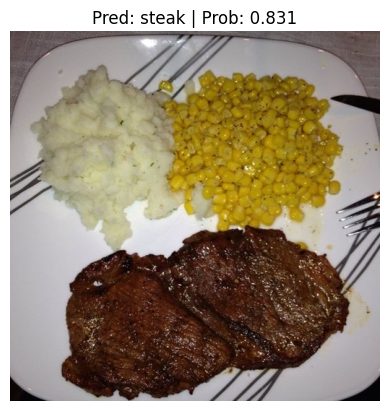

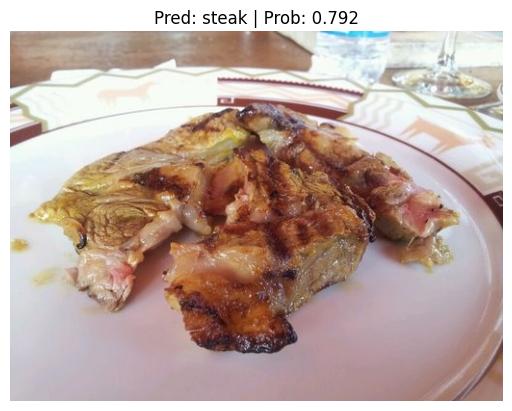

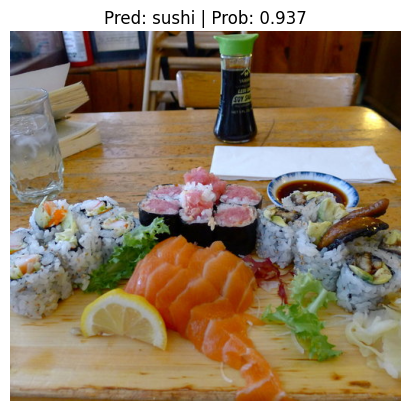

In [60]:
from going_modular.going_modular.predictions import pred_and_plot_image
import random
test_image_path_list = list(pathlib.Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k = 3)
for image_path in test_image_path_sample:
  pred_and_plot_image(model = best_model,
                      image_path = image_path,
                      class_names = classes,
                      image_size = (224, 224))

data/04-pizza-dad.jpeg already exists, skipping download.


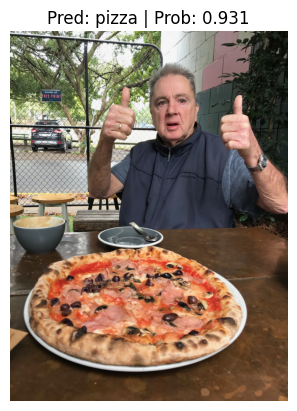

In [62]:
# predict on custom image with the best model
import requests

custom_image_path = Path("data/04-pizza-dad.jpeg")

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model = best_model,
                    image_path = custom_image_path,
                    class_names = classes
                    )